In [97]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats

#functions
import wrangle as wr
import explore as exp



warnings.filterwarnings("ignore")

#evaluate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from statsmodels.formula.api import ols
import sklearn.preprocessing

#feature engineering
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


## Acquire Data
Read zillow data from MySQL using the get_new_zillow_data() function in wrangle.py

In [2]:
df = wr.get_new_zillow_data()

In [3]:
#inspect
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


### Introduction to the data

learn about it's size, attributes, and components.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


In [5]:
#check for blanks/nulls
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8484
taxvaluedollarcnt                493
yearbuilt                       9337
taxamount                       4442
fips                               0
dtype: int64

In [6]:
def handle_nulls(df):    
    # We keep most of the data after dropping nulls
    # round(df.dropna().shape[0] / df.shape[0], 4) returned .9941
    df = df.dropna()
    return df

In [7]:
df = wr.handle_nulls(df)

In [8]:
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
dtype: int64

###  optimize data types, clean, handle outliers

In [9]:
def optimize_types(df):
    # Convert some columns to integers
    # fips, yearbuilt, and bedrooms can be integers
    df["fips"] = df["fips"].astype(str)
    df["yearbuilt"] = df["yearbuilt"].astype(int)
    df["bedroomcnt"] = df["bedroomcnt"].astype(int)    
    df["taxvaluedollarcnt"] = df["taxvaluedollarcnt"].astype(int)
    df["calculatedfinishedsquarefeet"] = df["calculatedfinishedsquarefeet"].astype(int)
    return df

In [10]:
df = wr.optimize_types(df)

In [11]:
#what about the outliers
df.bedroomcnt.describe(), df.bathroomcnt.describe(), df.calculatedfinishedsquarefeet.describe(),df.taxvaluedollarcnt.describe(),df.yearbuilt.describe()

(count    2.140235e+06
 mean     3.301419e+00
 std      9.325998e-01
 min      0.000000e+00
 25%      3.000000e+00
 50%      3.000000e+00
 75%      4.000000e+00
 max      2.500000e+01
 Name: bedroomcnt, dtype: float64,
 count    2.140235e+06
 mean     2.240352e+00
 std      9.905489e-01
 min      0.000000e+00
 25%      2.000000e+00
 50%      2.000000e+00
 75%      3.000000e+00
 max      3.200000e+01
 Name: bathroomcnt, dtype: float64,
 count    2.140235e+06
 mean     1.863194e+03
 std      1.221754e+03
 min      1.000000e+00
 25%      1.258000e+03
 50%      1.623000e+03
 75%      2.208000e+03
 max      9.525760e+05
 Name: calculatedfinishedsquarefeet, dtype: float64,
 count    2.140235e+06
 mean     4.606416e+05
 std      6.771576e+05
 min      2.200000e+01
 25%      1.891660e+05
 50%      3.282960e+05
 75%      5.346060e+05
 max      9.018846e+07
 Name: taxvaluedollarcnt, dtype: float64,
 count    2.140235e+06
 mean     1.960968e+03
 std      2.215056e+01
 min      1.801000e+03
 25%  

<AxesSubplot:xlabel='bedroomcnt'>

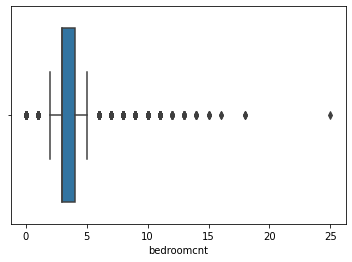

In [12]:
#visualize outliers
sns.boxplot(x='bedroomcnt', data=df)

<AxesSubplot:xlabel='bathroomcnt'>

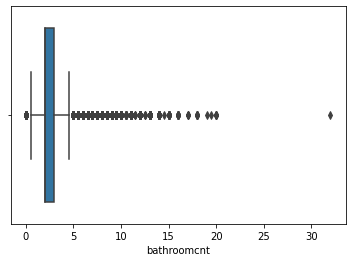

In [13]:
#visualize outliers
sns.boxplot(x='bathroomcnt', data=df)

<AxesSubplot:xlabel='calculatedfinishedsquarefeet'>

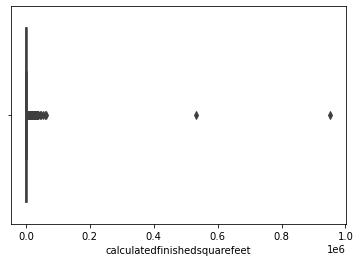

In [14]:
#visualize outliers
sns.boxplot(x='calculatedfinishedsquarefeet', data=df)

<AxesSubplot:xlabel='taxvaluedollarcnt'>

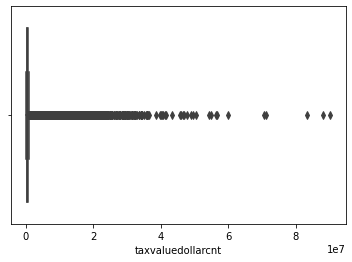

In [15]:
#visualize outliers
sns.boxplot(x='taxvaluedollarcnt', data=df)

<AxesSubplot:xlabel='yearbuilt'>

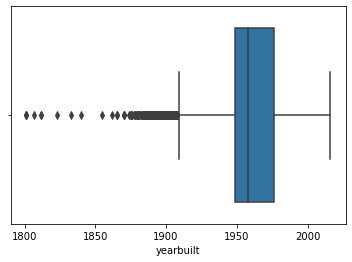

In [16]:
#visualize outliers
sns.boxplot(x='yearbuilt', data=df)

### looks like we can manually trim the data so as to remove the outliers skewing the data
### homes with more that 6 bedroom, more than 6 bathrooms, with less than 15000 sq ft, and less than 1500000 taxvaluedollarcnt

In [18]:
def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for 99% of buyers and zillow visitors"""
    df = df[df.bathroomcnt <= 6]
    
    df = df[df.bedroomcnt <= 6]

    df = df[df.taxvaluedollarcnt < 1_500_000]
    
    df.drop(df.loc[df.calculatedfinishedsquarefeet >15000].index, inplace=True)

    df.drop(df.loc[df['bedroomcnt']==0].index, inplace=True)
    
    df.drop(df.loc[df['bathroomcnt']==0].index, inplace=True)

    return df

In [19]:
df = wr.handle_outliers(df)

<AxesSubplot:xlabel='taxvaluedollarcnt'>

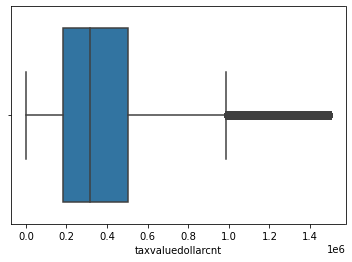

In [20]:
#inspect
sns.boxplot(x='taxvaluedollarcnt', data=df)

<AxesSubplot:xlabel='bathroomcnt'>

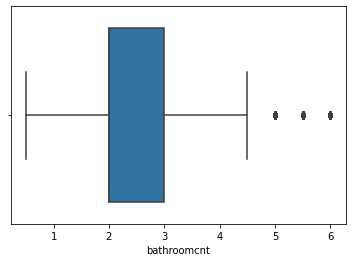

In [21]:
#inspect
sns.boxplot(x='bathroomcnt', data=df)

<AxesSubplot:xlabel='bedroomcnt'>

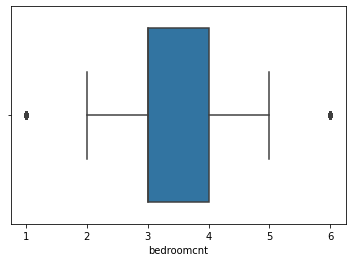

In [22]:
#inspect
sns.boxplot(x='bedroomcnt', data=df)

<AxesSubplot:xlabel='calculatedfinishedsquarefeet'>

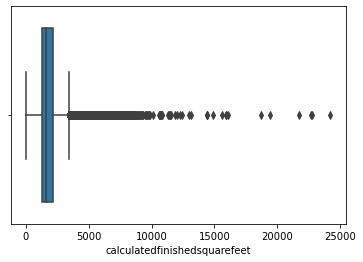

In [23]:
#visualize outliers
sns.boxplot(x='calculatedfinishedsquarefeet', data=df)

In [24]:
df.drop(df.loc[df.calculatedfinishedsquarefeet >15000].index, inplace=True)

### feature engineering and adjustment


In [25]:
    #new column total bill divided by size
df['cost_per_sqft'] = (df['taxvaluedollarcnt']/df['calculatedfinishedsquarefeet']).round(2)

    #avg sqft per number of rooms (bedroom+bathroom)
df['sqft_room_ratio'] = (df['calculatedfinishedsquarefeet']/(df['bedroomcnt']+df['bathroomcnt'])).round(2)

    #dummy encode fips
dummies = pd.get_dummies(df.fips)
df = pd.concat([df,dummies],axis=1)

In [26]:
#rename columns for ease of use
df=df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "sqft","taxvaluedollarcnt": "home_value"})

In [27]:
df

,bedrooms,bathrooms,sqft,home_value,yearbuilt,taxamount,fips,cost_per_sqft,sqft_room_ratio,6037.0,6059.0,6111.0
4,4,2.0,3633,296425,2005,6941.39,6037.0,81.59,605.50,1,0,0
6,3,4.0,1620,847770,2011,10244.94,6037.0,523.31,231.43,1,0,0
7,3,2.0,2077,646760,1926,7924.68,6037.0,311.39,415.40,1,0,0
18,3,1.0,1244,169471,1950,2532.88,6037.0,136.23,311.00,1,0,0
19,3,2.0,1300,233266,1950,3110.99,6037.0,179.44,260.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2152856,4,4.0,4375,422400,2015,13877.56,6037.0,96.55,546.88,1,0,0
2152858,4,3.0,2262,960756,2015,13494.52,6059.0,424.74,323.14,0,1,0
2152859,4,4.5,3127,536061,2014,6244.16,6059.0,171.43,367.88,0,1,0
2152861,3,2.5,1974,424353,2015,5302.70,6059.0,214.97,358.91,0,1,0


### Split  wrangled, cleaned, and prepped data
Using four functions tied to each other in wrangle.py file:

optimize_types(df):
handle_outliers(df)
split_zillow(df):





In [170]:
train, validate, test = wr.split(df, stratify_by=None)

In [171]:
train.shape, validate.shape, test.shape

((1153611, 12), (494406, 12), (412005, 12))

In [172]:
#scale data using scale_zillow function

In [173]:
train_scaled, validate_scaled, test_scaled = wr.scale_zillow(train, validate, test)

In [174]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((1153611, 12), (494406, 12), (412005, 12))

### explore data

list categoricals and quantitative features

<AxesSubplot:>

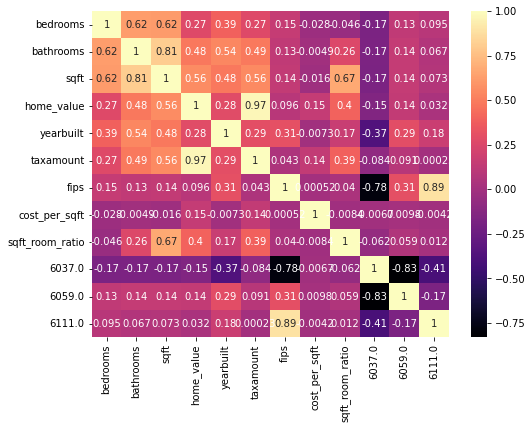

In [145]:
plt.figure(figsize=(8,6))
sns.heatmap(train_scaled.corr(), cmap='magma', annot=True)


Heat Map Takeaways:

high correlations between bedrooms, bathrooms, sqft, and sqft_room_ratio

count    1.153611e+06
mean     3.801968e+05
std      2.727847e+05
min      2.200000e+01
25%      1.844220e+05
50%      3.180890e+05
75%      5.047795e+05
max      1.499988e+06
Name: home_value, dtype: float64

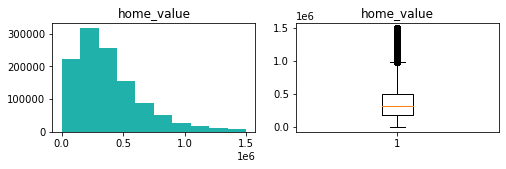

In [146]:
    descriptive_stats = train['home_value'].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train['home_value'], color='lightseagreen')
    p = plt.title('home_value')

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train['home_value'])
    p = plt.title('home_value')
    descriptive_stats

count    1.153611e+06
mean     1.774120e+03
std      7.472579e+02
min      1.000000e+00
25%      1.248000e+03
50%      1.599000e+03
75%      2.132000e+03
max      1.444400e+04
Name: sqft, dtype: float64

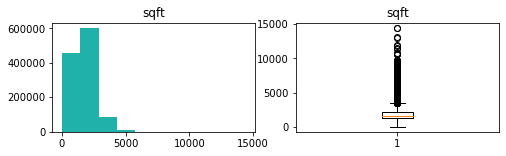

In [148]:
    descriptive_stats = train['sqft'].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train['sqft'], color='lightseagreen')
    p = plt.title('sqft')

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train['sqft'])
    p = plt.title('sqft')
    descriptive_stats

count    1.153611e+06
mean     3.268195e+00
std      8.734664e-01
min      1.000000e+00
25%      3.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      6.000000e+00
Name: bedrooms, dtype: float64

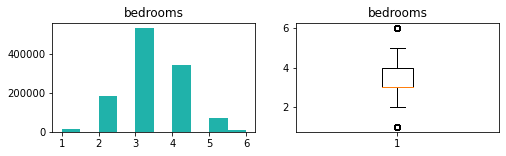

In [149]:
    descriptive_stats = train['bedrooms'].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train['bedrooms'], color='lightseagreen')
    p = plt.title('bedrooms')

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train['bedrooms'])
    p = plt.title('bedrooms')
    descriptive_stats

count    1.153611e+06
mean     2.164983e+00
std      8.441589e-01
min      5.000000e-01
25%      2.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      6.000000e+00
Name: bathrooms, dtype: float64

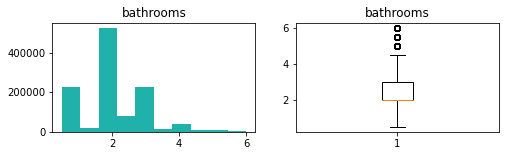

In [150]:
    descriptive_stats = train['bathrooms'].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train['bathrooms'], color='lightseagreen')
    p = plt.title('bathrooms')

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train['bathrooms'])
    p = plt.title('bathrooms')
    descriptive_stats

count    1.153611e+06
mean     2.189776e+02
std      6.956626e+02
min      1.000000e-02
25%      1.223500e+02
50%      1.976700e+02
75%      2.894400e+02
max      6.097510e+05
Name: cost_per_sqft, dtype: float64

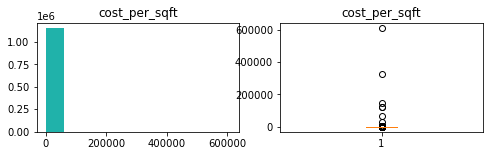

In [151]:
    descriptive_stats = train['cost_per_sqft'].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train['cost_per_sqft'], color='lightseagreen')
    p = plt.title('cost_per_sqft')

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train['cost_per_sqft'])
    p = plt.title('cost_per_sqft')
    descriptive_stats

count    1.153611e+06
mean     3.238696e+02
std      8.037433e+01
min      2.500000e-01
25%      2.666700e+02
50%      3.101200e+02
75%      3.662500e+02
max      4.374330e+03
Name: sqft_room_ratio, dtype: float64

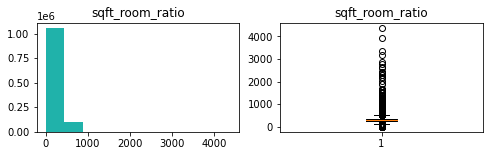

In [152]:
descriptive_stats = train['sqft_room_ratio'].describe()
plt.figure(figsize=(8,2))

p = plt.subplot(1, 2, 1)
p = plt.hist(train['sqft_room_ratio'], color='lightseagreen')
p = plt.title('sqft_room_ratio')

# second plot: box plot
p = plt.subplot(1, 2, 2)
p = plt.boxplot(train['sqft_room_ratio'])
p = plt.title('sqft_room_ratio')
descriptive_stats

In [153]:
def jointplot(x, y, df):
    '''
    jointplot will take in a feature("x") and a target("y") 
    and plot a corresponding scatter and distribution.
    '''
    
    p = sns.jointplot(x=x, y=y, data=df, kind="hex", color="mediumslateblue")
    
    return p

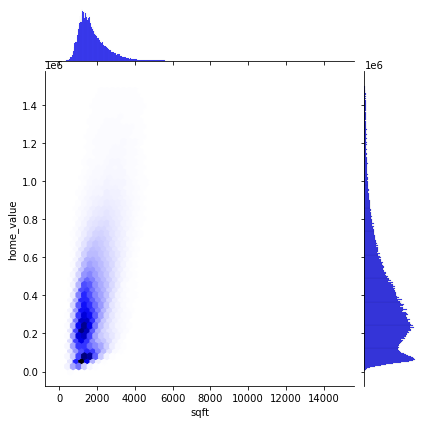

In [255]:
sns.jointplot(x='sqft', y='home_value', data=df, kind="hex", color="blue")

### This graph tells me a majority of homes are in the 
### bottom 20% of square feet and bottom 45% of home_value. 

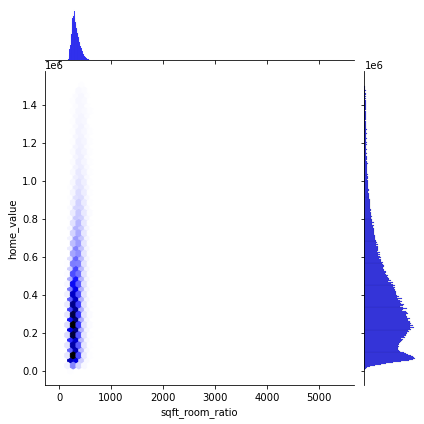

In [256]:
sns.jointplot(x='sqft_room_ratio', y='home_value', data=df, kind="hex", color="blue")


Hypothesis Testing

using a correlation_test function listed below to test my hypotheses as they are all concerning quantitative data.

In [157]:
def correlation_test(Ho, Ha, x, y):
    '''
    correlation_test will take in two arguments and 
    - plot a scatterplot of them
    - test the correlation
    return: the correlation coefficient, p, and if there is a linear relationship.
    '''
    
    splot = plt.scatter(x, y)
    
    null_hypothesis = Ho
    alternative_hypothesis = Ha
    
    confidence_level = .95
    a = 1 - confidence_level 
    
    corr, p = stats.pearsonr(x, y)

    if p < a:
        print(f"Reject null statment: {null_hypothesis}")
        print("There is a linear relationship.")
        if 0 < corr < .6:
            print("there is a positive weak one.")
        elif .6 < corr < 1:
            print("That is a stronger positive correlation.")
        elif -.6 < corr < 0:
            print("there is a negative weak one.")
        elif -1 < corr < -.6:
            print("That is a stronger negative correlation.")
        
    else : 
        print("Fail to reject the null hypothesis.")
        
    print(f"""
    Correlation Coefficient: {corr}
    p: {p}
    
    """)
    return splot

Test: There is a relationship between square footage and home value.

In [158]:
#assign your null hypothesis
Ho = "No correlation between square footage and home value."

#and your alternative hypothesis
Ha = "There is a correlation between square footage and home value."

#the feature you are testing
x1 = train_scaled.sqft

#against your target
y1 = train_scaled.home_value

Reject null statment: No correlation between square footage and home value.
There is a linear relationship.
there is a positive weak one.

    Correlation Coefficient: 0.5585526497929323
    p: 0.0
    
    


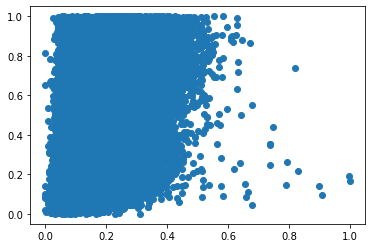

In [159]:
correlation_test(Ho, Ha, x1, y1)

Test: There is a weak correlation between number of bathrooms and home value.

In [160]:
Ho = "No correlation between number of bathrooms and home value."
Ha = "There IS a correlation between bathrooms and home value."
x2 = train_scaled.bathrooms
y2 = train_scaled.home_value

Reject null statment: No correlation between number of bathrooms and home value.
There is a linear relationship.
there is a positive weak one.

    Correlation Coefficient: 0.484619095836773
    p: 0.0
    
    


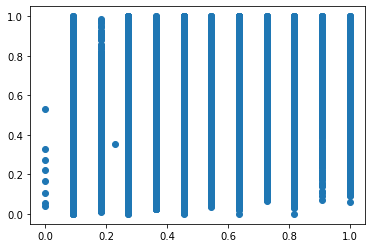

In [161]:
correlation_test(Ho, Ha, x2, y2)

Test: There is a relationship between number of bedrooms and home value.

In [162]:
Ho = "No correlation between number of bedrooms and home value."
Ha = "There IS a correlation between bedrooms and home value."
x3 = train_scaled.bedrooms
y3 = train_scaled.home_value

Reject null statment: No correlation between number of bedrooms and home value.
There is a linear relationship.
there is a positive weak one.

    Correlation Coefficient: 0.2670979461724933
    p: 0.0
    
    


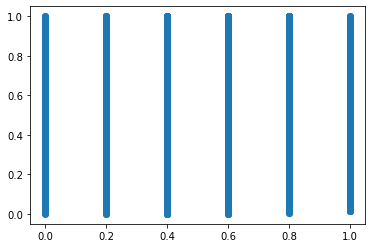

In [163]:
correlation_test(Ho, Ha, x3, y3)

Test: There is a relationship between square footage per room ratio and home value.

In [164]:
Ho = "No correlation between square footage per room ratio and home value."
Ha = "There IS a correlation between square footage per room ratio and home value."
x4 = train_scaled.sqft_room_ratio
y4 = train_scaled.home_value

Reject null statment: No correlation between square footage per room ratio and home value.
There is a linear relationship.
there is a positive weak one.

    Correlation Coefficient: 0.39658735460696176
    p: 0.0
    
    


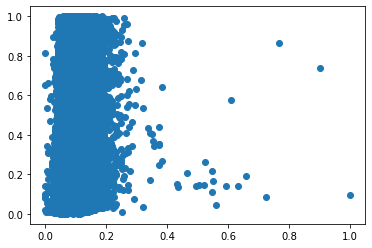

In [165]:
correlation_test(Ho, Ha, x4, y4)

### Evaluate Data

In [112]:
import model_zillow as mz

In [175]:
train

,bedrooms,bathrooms,sqft,home_value,yearbuilt,taxamount,fips,cost_per_sqft,sqft_room_ratio,6037.0,6059.0,6111.0
1088045,3,2.0,1068,47535,1959,567.16,6111.0,44.51,213.60,0,0,1
1457900,3,2.0,1542,847768,1941,9306.24,6037.0,549.78,308.40,1,0,0
115397,3,2.5,2174,306182,1964,3762.70,6059.0,140.84,395.27,0,1,0
506301,3,2.0,1359,156270,1973,1675.46,6111.0,114.99,271.80,0,0,1
641634,3,2.0,1200,79986,1977,1292.17,6037.0,66.66,240.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
463215,4,3.0,2029,328179,1994,3465.88,6111.0,161.74,289.86,0,0,1
1793012,3,1.0,1083,217072,1944,2819.76,6037.0,200.44,270.75,1,0,0
136986,3,2.0,2463,438091,1956,5110.96,6059.0,177.87,492.60,0,1,0
988610,3,2.5,1750,71543,1963,1104.14,6059.0,40.88,318.18,0,1,0


In [ ]:
#separate target from features that will be used and scale

In [259]:
X_train = train.drop(columns=['home_value','taxamount','fips','cost_per_sqft'])
X_validate = validate.drop(columns=['home_value','taxamount','fips','cost_per_sqft'])
X_test = test.drop(columns=['home_value','taxamount','fips','cost_per_sqft'])
y_train = train.home_value
y_validate = validate.home_value
y_test = test.home_value

In [260]:
X_train

,bedrooms,bathrooms,sqft,yearbuilt,sqft_room_ratio,6037.0,6059.0,6111.0
1088045,3,2.0,1068,1959,213.60,0,0,1
1457900,3,2.0,1542,1941,308.40,1,0,0
115397,3,2.5,2174,1964,395.27,0,1,0
506301,3,2.0,1359,1973,271.80,0,0,1
641634,3,2.0,1200,1977,240.00,1,0,0
...,...,...,...,...,...,...,...,...
463215,4,3.0,2029,1994,289.86,0,0,1
1793012,3,1.0,1083,1944,270.75,1,0,0
136986,3,2.0,2463,1956,492.60,0,1,0
988610,3,2.5,1750,1963,318.18,0,1,0


In [261]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_train)

train_mms = mms.transform(X_train)

In [262]:
#scaled back into df
X_train_scaled = pd.DataFrame(train_mms, columns=list(X_train.columns))

In [263]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_validate)

validate_mms = mms.transform(X_validate)

In [264]:
#scaled back into df
X_validate_scaled = pd.DataFrame(validate_mms, columns=list(X_validate.columns))

In [265]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_test)

test_mms = mms.transform(X_test)

In [266]:
#scaled back into df
X_test_scaled = pd.DataFrame(test_mms, columns=list(X_test.columns))

In [267]:
X_test_scaled

,bedrooms,bathrooms,sqft,yearbuilt,sqft_room_ratio,6037.0,6059.0,6111.0
0,0.6,0.363636,0.093689,0.750000,0.043249,0.0,1.0,0.0
1,0.4,0.272727,0.083451,0.779412,0.050089,0.0,1.0,0.0
2,0.4,0.272727,0.103927,0.857843,0.062373,0.0,1.0,0.0
3,0.4,0.272727,0.067354,0.632353,0.040431,1.0,0.0,0.0
4,0.4,0.090909,0.073079,0.661765,0.054837,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
412000,0.6,0.363636,0.145215,0.745098,0.067031,0.0,1.0,0.0
412001,0.2,0.090909,0.083047,0.686275,0.083090,1.0,0.0,0.0
412002,0.6,0.272727,0.084529,0.789216,0.042275,1.0,0.0,0.0
412003,0.2,0.090909,0.048427,0.607843,0.048472,1.0,0.0,0.0


In [268]:
# from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 3 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 8 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

In [269]:
f_feature

['bathrooms', 'sqft', 'yearbuilt', 'sqft_room_ratio']

In [270]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=4)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()

In [271]:
rfe_feature

['bathrooms', '6037.0', '6059.0', '6111.0']

### Modeling

In [272]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [273]:
#preview
y_train.head()

,home_value
1088045,47535
1457900,847768
115397,306182
506301,156270
641634,79986


####  Identify Baseline

In [274]:
# 1. compute pred_median
home_value_baseline_median = y_train['home_value'].median()
y_train['home_value_baseline_median'] = home_value_baseline_median
y_validate['home_value_baseline_median'] = home_value_baseline_median

# 2. compute pred_mean
home_value_baseline_mean = y_train['home_value'].mean()
y_train['home_value_baseline_mean'] = home_value_baseline_mean
y_validate['home_value_baseline_mean'] = home_value_baseline_mean

#check to see which is better
y_train.head()

,home_value,home_value_baseline_median,home_value_baseline_mean
1088045,47535,318089.0,380196.833903
1457900,847768,318089.0,380196.833903
115397,306182,318089.0,380196.833903
506301,156270,318089.0,380196.833903
641634,79986,318089.0,380196.833903


In [275]:
def plot_residuals(target, yhat):
    '''
    plot_residuals will take in a target series and prediction series
    and plot the residuals as a scatterplot.
    '''
    
    residual = target - yhat
    
    plt.scatter(target, residual)
    plt.axhline(y = 0, ls = ':')
    plt.xlabel("target")
    plt.ylabel("residual")
    plt.title('Residual Plot')
    plt.show

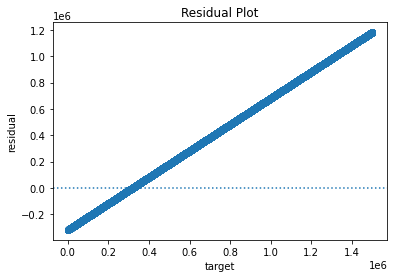

In [276]:
plot_residuals(y_train.home_value, y_train.home_value_baseline_median)

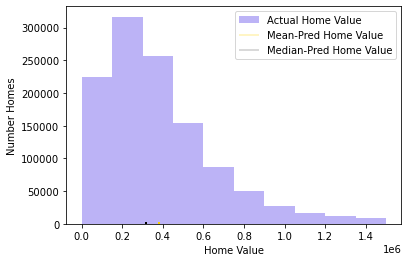

In [277]:
# plot to visualize actual vs predicted.
#median value performs better

plt.hist(y_train.home_value, color='mediumslateblue', alpha=.5, label="Actual Home Value")
plt.vlines(y_train.home_value_baseline_mean, 0, 3000, color='gold', alpha=.3, label="Mean-Pred Home Value")
plt.vlines(y_train.home_value_baseline_median, 0, 3000, color='black', alpha=.2, label="Median-Pred Home Value")
plt.xlabel("Home Value")
plt.ylabel("Number Homes")
plt.legend()
plt.show()

In [278]:
# 3. RMSE of hv_pred_median
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_baseline_median) ** (0.5)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_baseline_median) ** (0.5)

print(f"""
      BASELINE:
      
      RMSE using Median
      Train/In-Sample: {round(rmse_train, 2)}
      Validate/Out-of-Sample: {round(rmse_validate, 2)}
        """)


      BASELINE:
      
      RMSE using Median
      Train/In-Sample: 279765.61
      Validate/Out-of-Sample: 279423.34
        



### Train / Validate
Modeling: LinearRegression (OLS)

In [279]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.home_value)

# predict train
y_train['home_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm)**(0.5)

# predict validate
y_validate['home_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: {round(rmse_train_lm, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: 222808.75
    Validation/Out-of-Sample: 223201.38



### Modeling: LassoLars

In [280]:
# create the model object

lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.home_value)

# predict train
y_train['home_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.home_value, y_train.home_value_pred_lars)**(0.5)

# predict validate
y_validate['home_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lars)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

    RMSE for LassoLars
    
    Training/In-Sample: {round(rmse_train_lars, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 222808.75
                Validation/Out-of-Sample: 223201.38

    RMSE for LassoLars
    
    Training/In-Sample: 222941.29
    Validation/Out-of-Sample: 223345.81



### Modeling: TweedieRegressor (GLM)

In [281]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.home_value)

# predict train
y_train['home_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.home_value, y_train.home_value_pred_glm)**(0.5)

# predict validate
y_validate['home_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_glm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
    
    RMSE for TweedieRegressor (GLM)
    power=1, alpha=0
    
    Training/In-Sample: {round(rmse_train_glm, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 222808.75
                Validation/Out-of-Sample: 223201.38

                RMSE for LassoLars
                
                Training/In-Sample: 222941.29
                Validation/Out-of-Sample: 223345.81
    
    RMSE for TweedieRegressor (GLM)
    power=1, alpha=0
    
    Training/In-Sample: 272784.56
    Validation/Out-of-Sample: 272460.67



### Modeling: PolynomialFeatures

In [282]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [283]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.home_value)

# predict train
y_train['home_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm2)**(0.5)

# predict validate
y_validate['home_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm2)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: {round(rmse_train_glm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: {round(rmse_train_lm2, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 222808.75
                Validation/Out-of-Sample: 223201.38

                RMSE for LassoLars
                
                Training/In-Sample: 222941.29
                Validation/Out-of-Sample: 223345.81
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: 272784.56
                Validation/Out-of-Sample: 272460.67
                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: 218941.54
    Validation/Out-of-Sample: 219469.22



In [284]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf3.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf3.transform(X_validate)
X_test_degree3 = pf3.transform(X_test)

In [285]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.home_value)

# predict train
y_train['home_value_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train_lm3 = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm3)**(0.5)

# predict validate
y_validate['home_value_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate_lm3 = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm3)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: {round(rmse_train_glm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
                
                RMSE for Polynomial Regressor
                degrees=2
                
                Training/In-Sample: {round(rmse_train_lm2, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}
                
    
    RMSE for Polynomial Regressor
    degrees=3
    
    Training/In-Sample: {round(rmse_train_lm3, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm3, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 222808.75
                Validation/Out-of-Sample: 223201.38

                RMSE for LassoLars
                
                Training/In-Sample: 222941.29
                Validation/Out-of-Sample: 223345.81
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: 272784.56
                Validation/Out-of-Sample: 272460.67
                
                RMSE for Polynomial Regressor
                degrees=2
                
                Training/In-Sample: 218941.54
                Validation/Out-of-Sample: 219469.22
                
    
    RMSE for Polynomial Regressor
    degrees=3
    
    Training/In-Sample: 21

In [286]:
# make the polynomial features to get a new set of features
pf4 = PolynomialFeatures(degree=4)

# fit and transform X_train_scaled
X_train_degree4 = pf4.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree4 = pf4.transform(X_validate)
X_test_degree4 = pf4.transform(X_test)

In [287]:
# create the model object
lm4 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm4.fit(X_train_degree4, y_train.home_value)

# predict train
y_train['home_value_pred_lm4'] = lm4.predict(X_train_degree4)

# evaluate: rmse
rmse_train_lm4 = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm4)**(0.5)

# predict validate
y_validate['home_value_pred_lm4'] = lm4.predict(X_validate_degree4)

# evaluate: rmse
rmse_validate_lm4 = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm4)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 2)}
              Validate/Out-of-Sample: {round(rmse_validate, 2)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: {round(rmse_train_glm, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
                
                RMSE for Polynomial Regressor
                degrees=2
                
                Training/In-Sample: {round(rmse_train_lm2, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}
                
                RMSE for Polynomial Regressor
                degrees=3
                
                Training/In-Sample: {round(rmse_train_lm3, 2)}
                Validation/Out-of-Sample: {round(rmse_validate_lm3, 2)}
                
    
    RMSE for Polynomial Regressor
    degrees=4
    
    Training/In-Sample: {round(rmse_train_lm4, 2)}
    Validation/Out-of-Sample: {round(rmse_validate_lm4, 2)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 279765.61
              Validate/Out-of-Sample: 279423.34
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 222808.75
                Validation/Out-of-Sample: 223201.38

                RMSE for LassoLars
                
                Training/In-Sample: 222941.29
                Validation/Out-of-Sample: 223345.81
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: 272784.56
                Validation/Out-of-Sample: 272460.67
                
                RMSE for Polynomial Regressor
                degrees=2
                
                Training/In-Sample: 218941.54
                Validation/Out-of-Sample: 219469.22
                
                RMSE for Polynomial Regressor
                degrees=3
            

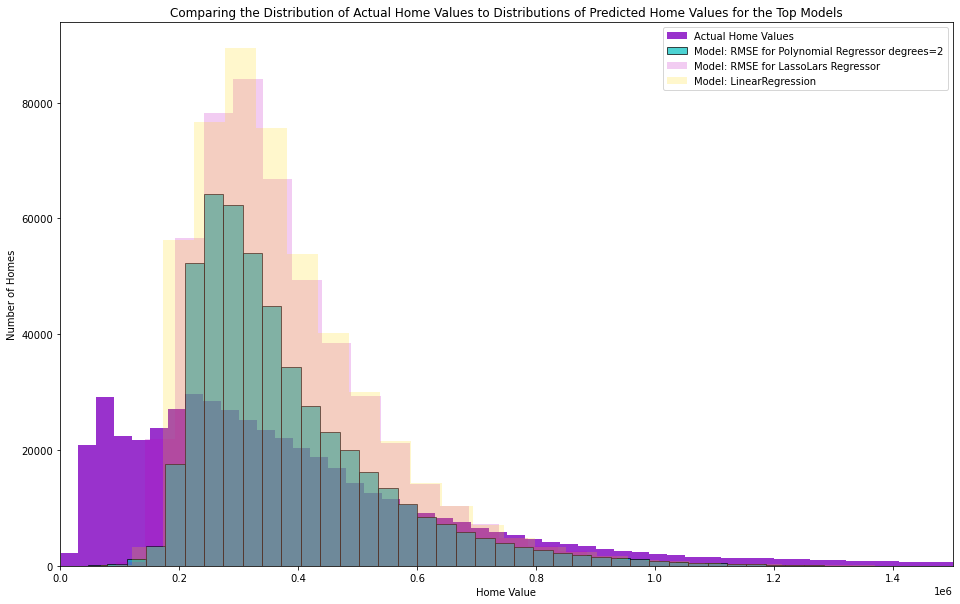

In [288]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.home_value, color='darkorchid', alpha=1, bins=50, label="Actual Home Values")
plt.hist(y_validate.home_value_pred_lm2, color='c', alpha=.7, bins=50, label="Model: RMSE for Polynomial Regressor degrees=2", ec='black')
#plt.hist(y_validate.home_value_pred_lm3, color='chartreuse', alpha=.2, bins=50, label="Model: RMSE for Polynomial Regressor degrees=3")
plt.hist(y_validate.home_value_pred_lars, color='m', alpha=.2, bins=50,label="Model: RMSE for LassoLars Regressor ")
plt.hist(y_validate.home_value_pred_lm, color='gold', alpha=.2, bins=50,label="Model: LinearRegression")
#plt.hist(y_validate.home_value_pred_lars, color='red', alpha=.5, bins=50, label="Model: RMSE for Tweedie Regressor")
plt.xlim(0, 1500000)
plt.xlabel("Home Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Home Values to Distributions of Predicted Home Values for the Top Models")
plt.legend()
plt.show()

### Test

In [289]:
y_test = pd.DataFrame(y_test)

#predict on test
y_test['home_value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.home_value, y_test.home_value_pred_lm2)**(0.5)

print(f"""
    RMSE for Polynomial Regressor degrees=2
    
    Test/Out-of-Sample Performance: {round(rmse_test, 2)}
""")


    RMSE for Polynomial Regressor degrees=2
    
    Test/Out-of-Sample Performance: 219647.25



## Summary
### Following the evaluation of the different models using my selected features, I found that the best performing model was the Polynomial Regressor with degrees = 2

### Looks like it performs best when above the median home value, and much worse below the median value

### Next Steps: look at how the data is skewed, and find a way to either scale it better to reduce that skew, or adjust the outliers towards the higher end of the data set to account for the majority of the homes on the lower end in order to improve model performance.